# Trabalho de IA 2
Matheus Augusto Schiavon Parise - 107115

Gabriel Colli Pavan - 109882

In [ ]:
import pandas as pd # Para manipulação de dados
import networkx as nx # Para desenhar gráficos
import matplotlib.pyplot as plt # Para desenhar gráficos
import matplotlib.cm as cm # Para as cores do plot
import itertools # Iteração entre cores # Talvez a retirar
import math # Para calculos matematicos

!pip install pybbn

# para a criação de Redes Bayesianas de Crenças (Bayesian Belief Networks (BBN))
import pybbn
from pybbn.graph.potential import Potential
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pybbn: filename=pybbn-3.2.3-py3-none-any.whl size=40391 sha256=885440956a8947eb45ae6c773b38be43752ff130c5390a326237606122d632ca
  Stored in directory: /root/.cache/pip/wheels/58/a0/8e/a1f7a3b884814cd8d15c791a7b161dfd7db021002a5a33e8f4
Successfully built pybbn


# Escolher variaveis que iremos usar no modelo
https://www.kaggle.com/datasets/hemanthsai7/loandefault

Variaveis para escolher do historio de empréstimo (35 no total)

ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status

In [ ]:
# Definindo as opções do Pandas para exibir mais colunas
pd.options.display.max_columns=50

# Ler as informações do historico de empréstimo
df=pd.read_csv('train.csv', encoding='utf-8')

# Remover registros onde a variavel de decisão final, "Loan Status" está vazia
df=df[pd.isnull(df['Loan Status'])==False]

# Preencher as colunas com valores ausentes com a média da coluna
df=df.fillna(df.mean())

# Primeiramente vamos exibir o data frame dos clientes inadimplentes
dfi = df[df['Loan Status'] == 1] # data frame cliente inadimplentes
dfi

<ipython-input-2-0af267b14db2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
15,9813088,27859,33502,16545.203070,36,BAT2833642,14.848190,B,A4,OWN,68062.59950,Source Verified,n,Credit card refinancing,17.715302,0,0,9,0,5904,44.388997,13,f,150.376663,0.039970,3.345747,0.627522,0,INDIVIDUAL,126,0,26,212092,15379,1
19,9038338,14058,26523,9622.342364,59,BAT2003848,14.523373,A,C1,MORTGAGE,48423.25999,Verified,n,Credit card refinancing,32.488893,6,0,26,0,18181,46.830204,16,f,1752.799012,32.289356,2.123521,1.056005,0,INDIVIDUAL,76,0,47,151581,9818,1
25,6688651,15330,21812,12374.390930,59,BAT4271519,8.971090,A,A5,MORTGAGE,71528.43557,Not Verified,n,Credit card refinancing,29.108776,0,0,10,0,1553,27.852533,14,f,551.724506,0.013079,1.931141,0.676965,0,INDIVIDUAL,88,0,430,34588,9411,1
44,36828690,31701,31200,23464.355250,59,BAT2803411,9.912737,E,B5,RENT,73168.38098,Verified,n,Credit card refinancing,19.882503,0,0,9,0,4583,60.959395,46,f,3178.229655,0.030438,0.936725,1.029249,0,INDIVIDUAL,139,0,570,118218,33597,1
61,11220256,4949,11569,15248.538030,58,BAT1104812,10.503262,B,B2,RENT,46663.01716,Source Verified,n,Credit card refinancing,15.739297,0,0,17,0,6849,64.905031,27,w,3306.925620,0.052173,4.784159,0.394677,0,INDIVIDUAL,155,0,41,27225,11498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67398,38336158,15939,8863,18915.327980,36,BAT2003848,11.859881,C,E1,RENT,61321.22951,Source Verified,n,Debt consolidation,25.214601,6,0,13,0,16852,75.264693,14,w,1449.456818,0.141947,1.689259,1.508336,0,INDIVIDUAL,49,0,2,185946,33165,1
67402,3299287,13164,17566,22375.288040,59,BAT4271519,9.998247,B,B1,MORTGAGE,57888.60981,Source Verified,n,Debt consolidation,18.917732,1,1,15,0,1564,9.136393,25,w,1024.741794,0.031158,3.184384,0.420233,0,INDIVIDUAL,94,0,43,181342,4530,1
67404,15326633,29162,8441,15449.629890,58,BAT1104812,7.899935,B,D2,MORTGAGE,19811.05072,Not Verified,n,Credit card refinancing,39.075648,0,0,18,0,2606,63.009023,9,w,381.749170,0.103524,10.206826,0.781853,0,INDIVIDUAL,88,0,36,420264,2080,1
67427,59234192,24027,22059,11084.285260,59,BAT3726927,11.373465,D,A1,MORTGAGE,84076.60589,Not Verified,n,Debt consolidation,21.130632,0,0,16,0,15977,83.168280,19,w,1723.949811,0.085734,1.629938,0.557907,0,INDIVIDUAL,4,0,49,21135,59007,1


In [ ]:
# É possivel observar algumas informações interessantes para usar como variaveis, como valor do emprestimo,
# porcentagem paga do emprestimo, quantidade que será paga por mês, taxa de juros, entre outros.

# Valores Medios dos casos Inadimplentes
Media_Valor_Emprestimo_Inadiplente = dfi['Loan Amount'].mean() # Valor de emprestimo do inadimplente (Dolar)
Media_Valor_Pago_Inadiplente = (dfi['Funded Amount']/dfi['Loan Amount']).mean() # Valor que já foi Pago / Valor emprestado = Valor Pago Total (%)
Media_QtdPagaNoMes_Inadiplente = dfi['Debit to Income'].mean() # Porcentagem do emprestimo paga ao mês (%)
Media_Juros_Inadiplente = dfi['Interest Rate'].mean() # Taxa de juros (% do valor total do emprestimo)

print("Valores do clientes inadimplentes:\n"
    + "Média dos valores de emprestimo: " + str(Media_Valor_Emprestimo_Inadiplente) + "\n"
    + "Média valor pago total (%): " + str(Media_Valor_Pago_Inadiplente) + "\n"
    + "Média da porcentagem do emprestimo paga ao mês (%): " + str(Media_QtdPagaNoMes_Inadiplente) + "\n"
    + "Média da taxa de juros (%): " + str(Media_Juros_Inadiplente) + "\n")

# Média de quem não é inadimplentes
dfni = df[df['Loan Status'] == 0] # data frame não inadimplente

Media_Valor_Emprestimo = dfni['Loan Amount'].mean() # Valor de emprestimo do inadimplente (Dolar)
Media_Valor_Pago = (dfni['Funded Amount']/dfni['Loan Amount']).mean() # Valor que já foi Pago / Valor emprestado = Valor Pago Total (%)
Media_QtdPagaNoMes = dfni['Debit to Income'].mean() # Porcentagem do emprestimo paga ao mês (%)
Media_Juros = dfni['Interest Rate'].mean() # Taxa de juros (% do valor total do emprestimo)

print("Valores do clientes NÃO inadimplentes:\n"
    + "Média dos valores de emprestimo: " + str(Media_Valor_Emprestimo) + "\n"
    + "Média valor pago total (%): " + str(Media_Valor_Pago) + "\n"
    + "Média da porcentagem do emprestimo paga ao mês (%): " + str(Media_QtdPagaNoMes) + "\n"
    + "Média da taxa de juros (%): " + str(Media_Juros) + "\n")

# % do valor emprestada paga por não inadimplente vs. inadimplente
[Media_Valor_Pago, Media_Valor_Pago_Inadiplente]

Valores do clientes inadimplentes:
Média dos valores de emprestimo: 16731.67441115206
Média valor pago total (%): 1.4016942608785445
Média da porcentagem do emprestimo paga ao mês (%): 23.218309556541584
Média da taxa de juros (%): 11.880031823501682

Valores do clientes NÃO inadimplentes:
Média dos valores de emprestimo: 16860.853092025744
Média valor pago total (%): 1.3679365495468265
Média da porcentagem do emprestimo paga ao mês (%): 23.307490770173725
Média da taxa de juros (%): 11.842814966824166



[1.3679365495468265, 1.4016942608785445]

In [ ]:
# Independente de conseguir pagar ou não o banco vai obter lucro pois em média seja o cliente inadimplente ou não!!! 
# A função de utilidade será feita  de acordo com o lucro obtido por parte do banco em relação a determinado cliente até o momento presente.
# Agora Vamos escolher as variaveis que serão usadas no modelo e definir as categorias para elas de acordo com as medias obtidas dos casos Inadimplentes

def setar_variaveis(df):
  # Valor do emprestimo
  df['Loan Amount Cat']=df['Loan Amount'].apply(lambda x: '0. <=10000'  if x<=10000 else
                                                          '1. 10000-25000' if 10000<x<=25000 else
                                                          '2. >25000')

  # Porcentagem paga do emprestimo
  df['Porcentagem paga'] = df['Funded Amount']/df['Loan Amount']
  df['Funded Amount Cat']=df['Porcentagem paga'].apply(lambda x: '0. <=0.5' if x <= 0.5 else
                                                                '1. >0.5') #if 0.5 < x <= 1.5 else
                                                                #'2. >1.5')

  # Quantidade que será paga por mês
  df['Debit to Income Cat']=df['Debit to Income'].apply(lambda x: '0. <=15' if x<=15 else
                                                                  '1. 15-30' if 15<x<=30 else
                                                                  '2. >30')

  # Taxa de juros
  df['Interest Rate Cat']=df['Interest Rate'].apply(lambda x: '0. <=8' if x<=8 else
                                                              '1. 8-15' if 7<x<=15 else
                                                              '2. >15')

setar_variaveis(df)
# Mostrando Dados
df

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status,Loan Amount Cat,Porcentagem paga,Funded Amount Cat,Debit to Income Cat,Interest Rate Cat
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0,0. <=10000,3.223600,1. >0.5,1. 15-30,1. 8-15
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0,0. <=10000,3.308396,1. >0.5,1. 15-30,1. 8-15
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0,2. >25000,0.329290,0. <=0.5,1. 15-30,1. 8-15
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0,1. 10000-25000,0.622560,1. >0.5,1. 15-30,2. >15
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0,1. 10000-25000,0.783067,1. >0.5,1. 15-30,2. >15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67458,16164945,13601,6848,13175.28583,59,BAT3193689,9.408858,C,A4,MORTGAGE,83961.15003,Verified,n,Credit card refinancing,28.105127,1,0,13,0,4112,97.779389,19,w,1978.945960,0.023478,564.614852,0.865230,0,INDIVIDUAL,69,0,48,181775,34301,1,1. 10000-25000,0.503492,1. >0.5,1. 15-30,1. 8-15
67459,35182714,8323,11046,15637.46301,59,BAT1780517,9.972104,C,B3,RENT,65491.12817,Source Verified,n,Credit card refinancing,17.694279,0,0,12,0,9737,15.690703,14,w,3100.803125,0.027095,2.015494,1.403368,0,INDIVIDUAL,14,0,37,22692,8714,0,0. <=10000,1.327166,1. >0.5,1. 15-30,1. 8-15
67460,16435904,15897,32921,12329.45775,59,BAT1761981,19.650943,A,F3,MORTGAGE,34813.96985,Verified,n,Lending loan,10.295774,0,0,7,1,2195,1.500090,9,w,2691.995532,0.028212,5.673092,1.607093,0,INDIVIDUAL,137,0,17,176857,42330,0,1. 10000-25000,2.070894,1. >0.5,0. <=15,2. >15
67461,5300325,16567,4975,21353.68465,59,BAT2333412,13.169095,D,E3,OWN,96938.83564,Not Verified,n,Debt consolidation,7.614624,0,0,14,0,1172,68.481882,15,f,3659.334202,0.074508,1.157454,0.207608,0,INDIVIDUAL,73,0,61,361339,39075,0,1. 10000-25000,0.300296,0. <=0.5,0. <=15,1. 8-15


In [ ]:
# Porcentagem de clientes que estão Inadimplente (=~ 10%) e porcentagem dos não Inadimplente (=~ 90%)
LS = df['Loan Status'].value_counts(normalize=True).sort_index()
LS

0    0.90749
1    0.09251
Name: Loan Status, dtype: float64

As probabilidades aqui são frequências normalizadas das categorias de variáveis dos dados.

In [ ]:
# As probabilidades aqui são frequências normalizadas das categorias de variáveis dos dados.
# Valor do emprestimo
LAC = df['Loan Amount Cat'].value_counts(normalize=True).sort_index()
LAC

0. <=10000        0.249500
1. 10000-25000    0.559373
2. >25000         0.191127
Name: Loan Amount Cat, dtype: float64

In [ ]:
# Porcentagem paga do emprestimo
FAC = df['Funded Amount Cat'].value_counts(normalize=True).sort_index()
FAC

0. <=0.5    0.223426
1. >0.5     0.776574
Name: Funded Amount Cat, dtype: float64

In [ ]:
# Quantidade que será paga por mês
DIC = df['Debit to Income Cat'].value_counts(normalize=True).sort_index()
DIC

0. <=15     0.179743
1. 15-30    0.568919
2. >30      0.251338
Name: Debit to Income Cat, dtype: float64

In [ ]:
# Taxa de juros
IRC = df['Interest Rate Cat'].value_counts(normalize=True).sort_index()
IRC

0. <=8     0.145235
1. 8-15    0.656197
2. >15     0.198568
Name: Interest Rate Cat, dtype: float64

In [ ]:
# Term aqui é o número de meses que o cliente tem para pagar o emprestimo, mas ele não é um 
# valor muito interressante pois só tem 3 opções: 36, 58 e 59. Como 58 e 59 são valores muito 
# próximos só é valido ressaltar que a maior parte das pessoas que pagaram suas dividas possuem um maior prazo
TC = df['Term'].value_counts(normalize=True).sort_index()
TC

36    0.021597
58    0.329455
59    0.648948
Name: Term, dtype: float64

In [ ]:
TC1 = dfi['Term'].value_counts(normalize=True).sort_index()
TC1

36    0.024676
58    0.294184
59    0.681141
Name: Term, dtype: float64

In [ ]:
TC2 = dfni['Term'].value_counts(normalize=True).sort_index()
TC2

36    0.021283
58    0.333050
59    0.645667
Name: Term, dtype: float64

In [ ]:
# Aqui é calculado na força bruta todas as possibilidades para cada uma das categorias
import numpy as np
tabela = []

for l in LAC:
  for f in FAC:
    for d in DIC:
      for i in IRC:
        res = l*f*d*i
        tabela.append(res)
x = np.reshape(tabela, (3,2,3,3)) # Em suma x[LAC, FAC, DIC, IRC]
x

array([[[[0.00145522, 0.00657491, 0.0019896 ],
         [0.00460603, 0.0208108 , 0.00629744],
         [0.00203486, 0.00919382, 0.00278209]],

        [[0.00505797, 0.02285277, 0.00691535],
         [0.01600941, 0.07233317, 0.02188835],
         [0.00707265, 0.03195543, 0.00966986]]],


       [[[0.00326257, 0.01474082, 0.00446064],
         [0.01032662, 0.04665739, 0.01411874],
         [0.00456211, 0.02061235, 0.00623739]],

        [[0.01133987, 0.05123544, 0.01550408],
         [0.03589276, 0.1621695 , 0.04907322],
         [0.01585674, 0.07164342, 0.02167962]]],


       [[[0.00111476, 0.00503665, 0.00152411],
         [0.00352841, 0.01594193, 0.0048241 ],
         [0.00155878, 0.00704284, 0.0021312 ]],

        [[0.00387461, 0.01750615, 0.00529744],
         [0.01226386, 0.05541017, 0.01676737],
         [0.00541794, 0.02447916, 0.00740751]]]])

In [ ]:
# Número de possibilidades
n_pos = len(LAC)*len(FAC)*len(DIC)*len(IRC)

# A soma de x deve ser igual á 1
print("A soma total é: " + str(x.sum()) + ", Já o número de elementos é: " + str(n_pos) 
+ "\nComo existe uma decisão com duas possibilidades 'Sim' ou 'Não'\nentão 2 x " + str(n_pos) + " = " + str(2*n_pos))

A soma total é: 1.0, Já o número de elementos é: 54
Como existe uma decisão com duas possibilidades 'Sim' ou 'Não'
então 2 x 54 = 108


In [ ]:
# Esta função ajuda a calcular a distribuição de probabilidade, que vai para BBN (nota, pode lidar com até 4 pais)
# Há uma certa desconfiança por trás do número de possibilidades gerado por crosstab então vamos averiguar logo em seguida
# se o número bate.
def probs(data, child, parent1=None, parent2=None, parent3=None, parent4=None):
    if parent1==None:
        # Calcular probabilidades
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Verifique se o nó filho tem 1 pai ou 2 pais
            if parent2==None:
                # Calcular probabilidades
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:
                # Verifique se o nó filho tem 2 pai ou 3 pais
                if parent3==None:
                    # Caclucate probabilities
                    prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
                else:
                    #Verifique se o nó filho tem 3 pai ou 4 pais
                    if parent4==None:
                        # Calcular probabilidades
                        prob=pd.crosstab([data[parent1],data[parent2],data[parent3]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
                    else:
                        # Calcular probabilidades
                        prob=pd.crosstab([data[parent1],data[parent2],data[parent3],data[parent4]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Erro nos cálculos de frequência de probabilidade")
    return prob

In [ ]:
# Averiguando a funcionalidade da função da biblioteca (crosstab)
verifica_biblioteca = probs(df, child='Loan Status', parent1='Loan Amount Cat', parent2='Debit to Income Cat', parent3='Interest Rate Cat', parent4='Funded Amount Cat') #, parent2='Funded Amount Cat') #, 

# Se len(verifica_biblioteca) for igual á 2 * n_pos então crosstab está correta !
len(verifica_biblioteca) == 2 * n_pos

True

In [ ]:
def criar_rede(df, df2):
  # Crie nós usando nossa função anterior para calcular probabilidades automaticamente
  LA = BbnNode(Variable(0, 'LA', ['0. <=10000', '1. 10000-25000', '2. >25000']), probs(df, child='Loan Amount Cat'))
  FA = BbnNode(Variable(1, 'FA', ['0. <=0.5', '1. >0.5']), probs(df, child='Funded Amount Cat'))
  DI = BbnNode(Variable(2, 'DI', ['0. <=15', '1. 15-30', '2. >30']), probs(df, child='Debit to Income Cat'))
  IR = BbnNode(Variable(3, 'IR', ['0. <=8', '1. 8-15', '2. >15']), probs(df, child='Interest Rate Cat'))
  LS = BbnNode(Variable(4, 'LS', ['No', 'Yes']), probs(df2, child='Loan Status', parent1='Loan Amount Cat', parent2='Funded Amount Cat', parent3='Debit to Income Cat', parent4='Interest Rate Cat'))

  # Criar rede
  bbn = Bbn() \
      .add_node(LA) \
      .add_node(FA) \
      .add_node(DI) \
      .add_node(IR) \
      .add_node(LS) \
      .add_edge(Edge(LA, LS, EdgeType.DIRECTED)) \
      .add_edge(Edge(FA, LS, EdgeType.DIRECTED)) \
      .add_edge(Edge(DI, LS, EdgeType.DIRECTED)) \
      .add_edge(Edge(IR, LS, EdgeType.DIRECTED))

  # Converter o BBN em uma árvore de junção
  join_tree = InferenceController.apply(bbn)
  return  bbn, join_tree

bbn, join_tree = criar_rede(df, df)

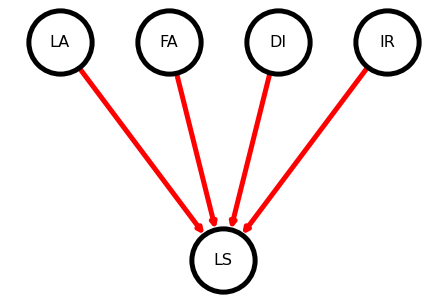

In [ ]:
# Definir as posições dos nós (horizontal, vertical)
pos = {0: (-0.3, 1), 1: (-0.1, 1), 2: (0.1, 1), 3: (0.3, 1), 4: (0, -0.5)}

# Definir opções para a aparência do gráfico
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}

# Gerar gráfico
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Atualize as margens e imprima o gráfico
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [ ]:
# O Grafico acima representa a dependencia e independencia entre as variaveis
# Defina uma função para imprimir as probabilidades
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')

# Use a função acima para imprimir probabilidades
print_probs()

Node: 1|FA|0. <=0.5,1. >0.5
Values:
1=0. <=0.5|0.22343
1=1. >0.5|0.77657
----------------
Node: 2|DI|0. <=15,1. 15-30,2. >30
Values:
2=0. <=15|0.17974
2=1. 15-30|0.56892
2=2. >30|0.25134
----------------
Node: 3|IR|0. <=8,1. 8-15,2. >15
Values:
3=0. <=8|0.14524
3=1. 8-15|0.65620
3=2. >15|0.19857
----------------
Node: 4|LS|No,Yes
Values:
4=No|0.90847
4=Yes|0.09153
----------------
Node: 0|LA|0. <=10000,1. 10000-25000,2. >25000
Values:
0=0. <=10000|0.24950
0=1. 10000-25000|0.55937
0=2. >25000|0.19113
----------------


In [ ]:
# Para adicionar evidências de eventos que aconteceram para que a distribuição de probabilidade possa ser recalculada
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

# Vamos supor que todos os emprestimos seja menores que 10 mil dolares, em teoria
# seria mais facil pagar as dividas se o emprestimo for menor
evidence('ev1', 'LA', '0. <=10000', 1.0)

# Imprimir probabilidades novas
print_probs()

Node: 1|FA|0. <=0.5,1. >0.5
Values:
1=0. <=0.5|0.22343
1=1. >0.5|0.77657
----------------
Node: 2|DI|0. <=15,1. 15-30,2. >30
Values:
2=0. <=15|0.17974
2=1. 15-30|0.56892
2=2. >30|0.25134
----------------
Node: 3|IR|0. <=8,1. 8-15,2. >15
Values:
3=0. <=8|0.14524
3=1. 8-15|0.65620
3=2. >15|0.19857
----------------
Node: 4|LS|No,Yes
Values:
4=No|0.90846
4=Yes|0.09154
----------------
Node: 0|LA|0. <=10000,1. 10000-25000,2. >25000
Values:
0=0. <=10000|1.00000
0=1. 10000-25000|0.00000
0=2. >25000|0.00000
----------------


In [ ]:
# Em um segundo caso vamos alterar as possibilidades para tentar maximizar as
# condições que favorecem a inadimplencia
evidence('ev1', 'IR', '2. >15', 1.0)
evidence('ev2', 'DI', '2. >30', 1.0)
evidence('ev3', 'FA', '0. <=0.5', 1.0)
evidence('ev4', 'LA', '2. >25000', 1.0)

# Imprimir probabilidades novamente
print_probs()

Node: 1|FA|0. <=0.5,1. >0.5
Values:
1=0. <=0.5|1.00000
1=1. >0.5|0.00000
----------------
Node: 2|DI|0. <=15,1. 15-30,2. >30
Values:
2=0. <=15|0.00000
2=1. 15-30|0.00000
2=2. >30|1.00000
----------------
Node: 3|IR|0. <=8,1. 8-15,2. >15
Values:
3=0. <=8|0.00000
3=1. 8-15|0.00000
3=2. >15|1.00000
----------------
Node: 4|LS|No,Yes
Values:
4=No|0.90857
4=Yes|0.09143
----------------
Node: 0|LA|0. <=10000,1. 10000-25000,2. >25000
Values:
0=0. <=10000|0.00000
0=1. 10000-25000|0.00000
0=2. >25000|1.00000
----------------


In [ ]:
# Vamos calcular o gráfico de utilidade. Como 67 mil registros demora de mais, então irei utilizar apenas 10%
# do dataframe de forma que eu pegue 10% dos inadimplentes e dos não inadimplentes dessa forma a proporção final não será alterada
dfi_10p = dfi.sample(frac=0.1) # 10% dos inadimplentes
dfni_10p = dfni.sample(frac=0.1) # 10% dos NÃO inadimplentes

# Juntando as duas partes
frames = [dfi_10p, dfni_10p]
df_10p = pd.concat(frames)
print("dfi + dfni = ?\n" + str(len(dfi_10p)), "+",len(dfni_10p),"=", len(dfi_10p)+len(dfni_10p))
df_10p

dfi + dfni = ?
624 + 6122 = 6746


,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
59972,5345826,7295,7807,20287.135400,59,BAT2522922,8.408752,B,C1,MORTGAGE,59788.01218,Source Verified,n,debt loan,18.270145,1,0,30,0,8293,17.231777,30,w,425.812446,0.047090,8.444140,0.086809,0,INDIVIDUAL,153,0,40,106474,8640,1
62664,60533655,21266,22903,10024.601650,59,BAT2833642,11.465754,D,A4,MORTGAGE,64342.72812,Source Verified,n,Credit card refinancing,9.155543,1,0,10,0,146,94.795084,12,f,4345.561678,0.096180,5.437898,0.281461,0,INDIVIDUAL,85,0,34,74292,1013,1
28046,29886046,2337,5143,15822.272930,59,BAT2333412,17.379547,D,D4,OWN,54766.84084,Not Verified,n,Personal,10.713615,1,0,7,0,544,48.767884,12,f,18.502779,0.083051,1.407276,0.750847,0,INDIVIDUAL,144,0,48,257699,41457,1
7264,10650690,20358,31984,24675.868990,59,BAT1930365,16.094360,A,E1,MORTGAGE,61760.35959,Source Verified,n,Credit card refinancing,29.635895,0,0,15,1,1917,42.853992,19,w,1366.323485,0.061730,0.454281,1.185792,0,INDIVIDUAL,89,0,27,29832,28265,1
12179,7279729,30597,9615,14730.438440,59,BAT4694572,16.589264,E,F2,RENT,60076.67039,Not Verified,n,Home improvement,30.597889,0,1,12,0,6359,87.109728,38,w,793.758028,0.015196,0.331134,1.226117,0,INDIVIDUAL,47,0,27,398451,8733,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61169,4520644,25674,3176,14418.986890,59,BAT4808022,12.586896,B,A5,MORTGAGE,33327.45118,Source Verified,n,Credit card refinancing,8.113286,0,0,13,0,51,81.715879,22,f,69.836896,0.001533,3.709630,0.539153,1,INDIVIDUAL,55,0,50,473269,2279,0
64476,46957719,3738,28459,12220.153920,59,BAT2078974,12.833815,A,G2,MORTGAGE,66403.37435,Verified,n,debt consolidation,12.649651,0,0,22,0,18246,65.032086,39,w,9741.833761,0.035405,0.300193,1.251040,0,INDIVIDUAL,31,0,25,36131,46648,0
23242,42222801,27494,15524,7681.809218,59,BAT5525466,14.489862,B,B5,RENT,162889.32200,Not Verified,n,Debt Consolidation,24.335442,1,0,11,0,6365,48.973914,15,f,7715.653671,0.033731,2.737172,1.036773,0,INDIVIDUAL,152,0,33,17645,8876,0
31458,11857173,8561,20005,31031.251540,59,BAT4136152,16.271247,B,B4,RENT,297054.18150,Source Verified,n,Debt consolidation,38.435609,0,0,12,0,3780,62.331108,20,f,650.178378,0.106039,3.768038,0.807801,0,INDIVIDUAL,82,0,33,482693,53403,0


In [ ]:
# Categorizando a Utilidade pelo dinheiro obtido até o momento, isto é o valor emprestado menos valor pago
df_10p['Utilidade'] = df_10p['Funded Amount'] - df_10p['Loan Amount'] # Criando a coluna de utilidade
Lista_Ordenada = df_10p['Utilidade'].sort_values() # Ordenando os valores financeiros
df_10p['Index'] = [i for i in range(0, len(df_10p))] # Criando uma lista de index com base no tamanho de 10% do dataframe

Lista_Ordenada

5609    -30442
57855   -30358
23168   -30140
2235    -29679
37508   -29488
         ...  
10101    31118
39822    31730
65736    31925
29587    31988
30752    33532
Name: Utilidade, Length: 6746, dtype: int64

In [ ]:
# Normalizando a lista ordenada para saber proporção dos clientes o qual foi possivel obter lucro até o momento
Lista_Normalizada = Lista_Ordenada.apply(lambda x: '0. < 0'  if x < 0 else
                                                   '1. == 0' if x == 0 else
                                                   '2. > 0')
print("Clientes que deram prejuiso: ", len(Lista_Normalizada[Lista_Normalizada == '0. < 0']))
print("Clientes que pagaram exatamente o que pediram emprestado: ", len(Lista_Normalizada[Lista_Normalizada == '1. == 0']))
print("Clientes que deram lucro: ", len(Lista_Normalizada[Lista_Normalizada == '2. > 0']), "\n")
Lista_Normalizada.value_counts(normalize=True).sort_index()

Clientes que deram prejuiso:  3657
Clientes que pagaram exatamente o que pediram emprestado:  0
Clientes que deram lucro:  3089 



0. < 0    0.542099
2. > 0    0.457901
Name: Utilidade, dtype: float64

Tamanhos iguais?:  6746 6746 True


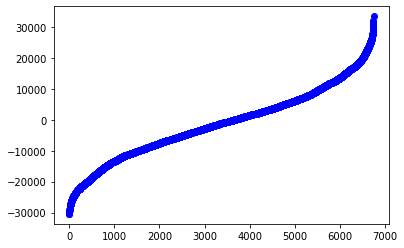

In [ ]:
# Modelo gráfico inicial
xs = df_10p['Index']
ys = (df_10p['Utilidade'].sort_values())

if xs.size == ys.size:
  print("Tamanhos iguais?: ", xs.size, ys.size, xs.size == ys.size)
  # colors = cm.rainbow(np.linspace(0, 1, len(ys)))
  # for y, c in zip(ys, colors):
  #     plt.scatter(x, y, color=c)
  colors = itertools.cycle(["r", "b", "g"])
  for x,y in zip(xs,ys):
    plt.scatter(x, y, color="b") # next(colors))

Tamanhos iguais?:  6746 6746 True


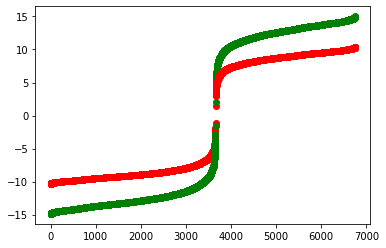

In [ ]:
# Caso o logaritmo na base dois seja aplicado é possivel ver algo similiar a dedução de Grayson (1960)
# em relação que a utilidade do dinheiro é proporcional ao logaritmo da quantia.
if xs.size == ys.size:
  print("Tamanhos iguais?: ", xs.size, ys.size, xs.size == ys.size)
  colors = itertools.cycle(["r", "b", "g"])
  for x,y in zip(xs,ys):
    valor_ln, valor_l2 = 0,0
    if y < 0:
      valor_ln = -(np.log(-y)) # /np.log(2))
      valor_l2 = -(np.log(-y)/np.log(2))
    else:
      valor_ln = np.log(y) # /np.log(2)
      valor_l2 = np.log(y)/np.log(2)
    plt.scatter(x, valor_ln, color="r") # Logaritmo natural
    plt.scatter(x, valor_l2, color="g") # Logaritmo na base 2

In [ ]:
# Abriando a base de teste 
dft = pd.read_csv('test.csv', encoding='utf-8')
dft

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,56492997,17120,10365,16025.082690,59,BAT2575549,12.163926,A,D1,RENT,76468.82190,Source Verified,n,Home improvement,16.749219,1,0,12,1,3576,67.278287,5,f,4469.449851,0.088031,8.425776,0.731797,0,INDIVIDUAL,135,0,24,475442,4364,NaN
1,22540813,7133,11650,12615.795600,59,BAT2833642,6.564296,B,E3,MORTGAGE,38079.01344,Source Verified,n,Credit card refinancing,18.157975,0,0,11,0,1932,71.313157,21,w,993.907530,0.041237,6.157008,0.992918,0,INDIVIDUAL,56,0,1,72412,2573,NaN
2,9862181,25291,25825,11621.280830,59,BAT1761981,14.729900,A,C3,MORTGAGE,51275.93268,Source Verified,n,Debt consolidation,15.190011,0,0,22,0,598,50.883065,23,f,729.113379,0.021745,5.705077,0.281580,0,INDIVIDUAL,3,0,26,284825,19676,NaN
3,10097822,30781,9664,15375.823510,59,BAT5341619,10.523767,A,A2,RENT,68867.98965,Verified,n,Debt Consolidation,21.292550,0,0,11,0,5222,82.449083,28,w,715.867091,0.092398,2.469688,0.959162,0,INDIVIDUAL,21,0,32,40842,7226,NaN
4,47771809,8878,9419,7176.647582,58,BAT4694572,9.997013,C,B3,OWN,91556.85423,Verified,n,Debt consolidation,4.812117,0,0,11,0,553,49.075855,9,w,248.572854,0.010354,2.127835,0.402315,0,INDIVIDUAL,104,0,33,90825,26145,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28908,11537800,35000,35000,35000.000000,60,BAT5629144,16.240000,C,C5,MORTGAGE,360000.00000,Verified,n,Credit card refinancing,7.310000,0,0,8,1,83274,72.200000,16,f,10116.330000,0.000000,0.000000,0.000000,0,INDIVIDUAL,109,0,0,883984,114000,NaN
28909,11538258,25000,25000,25000.000000,60,BAT5629144,14.980000,C,C3,MORTGAGE,105000.00000,Source Verified,n,Debt consolidation,10.220000,0,1,10,0,26356,50.900000,26,f,6493.950000,0.000000,0.000000,0.000000,0,INDIVIDUAL,104,0,0,513925,51800,NaN
28910,13147685,30000,30000,29950.000000,60,BAT2136391,18.240000,D,D5,MORTGAGE,74100.00000,Verified,n,Debt consolidation,27.300000,0,0,19,0,31303,47.700000,45,f,7785.190000,0.000000,0.000000,0.000000,1,INDIVIDUAL,83,0,0,296294,65600,NaN
28911,13917689,25000,25000,24950.000000,60,BAT2136391,15.610000,D,D1,MORTGAGE,130000.00000,Verified,n,Debt consolidation,27.290000,2,0,12,0,25470,83.800000,34,f,5513.520000,0.000000,0.000000,0.000000,0,INDIVIDUAL,83,0,0,428723,30400,NaN


In [ ]:
# Pega cem amostras aleatorias
dfts = dft.sample(n=100)

# Seta as variaveis para a base de teste
setar_variaveis(dft)

# Refaz a arvore com a base de teste e calcula posteriori
bbn, join_tree = criar_rede(dft, df)

lista_porcentagem = []
for i in range(0,len(dfts)):
  # Colocando a evidencia de acordo com o cliente especifico
  evidence('ev1', 'IR', dfts.iloc[i]['Interest Rate Cat'], 1.0)
  evidence('ev2', 'DI', dfts.iloc[i]['Debit to Income Cat'], 1.0)
  evidence('ev3', 'FA', dfts.iloc[i]['Funded Amount Cat'], 1.0)
  evidence('ev4', 'LA', dfts.iloc[i]['Loan Amount Cat'], 1.0)

  # Obtém a tabela de probabilidade condicional do nó
  node = join_tree.get_bbn_nodes()[3]
  potential = join_tree.get_bbn_potential(node)

  # Tratando resposta
  r = str(potential)
  r = r.split('|')
  r = [float(r[1][:7]), float(r[2])] # No | Yes
  lista_porcentagem.append(r[0]) # Adicionando na lista de probabilidades

# Registrando a chance de não inadimplencia e fazendo a decisão final
# neste caso se a chance de não inadimplencia for maior que 90% ele faz
# o emprestimo
dfts['Chace não inadimplente'] = lista_porcentagem
dfts['Decisão']=dfts['Chace não inadimplente'].apply(lambda x: 'Não' if x < 0.9 else
                                                               'Sim') 

dfts

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status,Loan Amount Cat,Porcentagem paga,Funded Amount Cat,Debit to Income Cat,Interest Rate Cat,Chace não inadimplente,Decisão
2456,15551679,28082,22428,11182.102160,59,BAT4722912,8.463654,B,B2,MORTGAGE,55431.12267,Source Verified,n,Debt consolidation,17.482627,1,0,15,0,101,67.021439,10,w,1732.096085,0.012591,1.854713,0.974701,0,INDIVIDUAL,36,0,39,15681,9160,NaN,2. >25000,0.798661,1. >0.5,1. 15-30,1. 8-15,0.91467,Sim
27910,11922690,8000,8000,8000.000000,36,BAT1766061,11.990000,B,B3,MORTGAGE,140000.00000,Verified,n,Credit card refinancing,3.210000,0,1,9,1,11873,58.500000,39,f,1366.570000,0.000000,0.000000,0.000000,0,INDIVIDUAL,104,0,0,300101,20300,NaN,0. <=10000,1.000000,1. >0.5,0. <=15,1. 8-15,0.90135,Sim
16507,32517639,21092,10840,19917.901630,59,BAT1586599,10.394450,C,D1,RENT,98101.21593,Not Verified,n,Debt consolidation,13.858917,0,0,13,1,8422,58.036154,7,f,185.042345,0.051728,5.077999,0.591753,0,INDIVIDUAL,11,0,19,144841,1398,NaN,1. 10000-25000,0.513939,1. >0.5,0. <=15,1. 8-15,0.90811,Sim
12189,50021601,33764,4906,8459.549479,58,BAT5547201,11.889843,C,C4,MORTGAGE,19356.67143,Source Verified,n,Credit card refinancing,15.301421,1,0,13,0,9017,51.578948,17,w,1045.536752,0.046783,7.092932,0.438713,0,INDIVIDUAL,126,0,41,92517,11431,NaN,2. >25000,0.145303,0. <=0.5,1. 15-30,1. 8-15,0.90261,Sim
28902,13296958,35000,35000,35000.000000,36,BAT1766061,13.980000,C,C1,MORTGAGE,140000.00000,Verified,n,Debt consolidation,23.430000,0,2,15,0,33447,60.400000,43,w,6854.300000,0.000000,0.000000,0.000000,0,INDIVIDUAL,104,0,0,395571,55400,NaN,2. >25000,1.000000,1. >0.5,1. 15-30,1. 8-15,0.90701,Sim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26486,13290690,3200,3200,3200.000000,36,BAT224923,11.990000,B,B3,MORTGAGE,77000.00000,Verified,n,Other,10.800000,0,2,10,0,7869,22.600000,31,f,234.580000,0.000000,0.000000,0.000000,0,INDIVIDUAL,35,0,0,237410,34800,NaN,0. <=10000,1.000000,1. >0.5,0. <=15,1. 8-15,0.89941,Não
24896,45340419,13000,13000,12950.000000,36,BAT4136152,9.990000,B,B3,RENT,65000.00000,Not Verified,n,Credit card refinancing,20.460000,0,0,9,0,13902,70.900000,9,f,948.610000,0.000000,0.000000,0.000000,0,INDIVIDUAL,44,0,0,36279,19600,NaN,1. 10000-25000,1.000000,1. >0.5,1. 15-30,1. 8-15,0.90739,Sim
28719,11538106,32000,32000,31925.000000,60,BAT5629144,13.980000,C,C1,MORTGAGE,78000.00000,Source Verified,n,Debt consolidation,18.060000,1,0,9,0,21084,73.200000,26,f,7643.100000,0.000000,0.000000,0.000000,0,INDIVIDUAL,104,0,110,227780,28800,NaN,2. >25000,1.000000,1. >0.5,1. 15-30,1. 8-15,0.90808,Sim
10783,28003990,20330,22793,5846.636276,59,BAT1930365,12.600412,D,B3,RENT,66625.07812,Verified,n,Credit card refinancing,12.763867,0,0,12,0,21826,86.191252,11,w,1903.873479,0.072440,2.058093,0.477953,0,INDIVIDUAL,7,0,30,596437,34307,NaN,1. 10000-25000,1.121151,1. >0.5,0. <=15,1. 8-15,0.91068,Sim


In [ ]:
# Aqui está a normalização dos valores de decisão final
D = dfts['Decisão'].value_counts(normalize=True).sort_index()
D

Não    0.05
Sim    0.95
Name: Decisão, dtype: float64